In [3]:
import datetime
import ee
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import os
import geopandas as gp
from dateutil.relativedelta import relativedelta
from scipy import stats

ee.Initialize()

In [4]:
def init():
    
    '''
    Set the init params:
    1) Area
    2) Satellite 
    3) Years to analyze 
    
    '''
    
    ##### AREA #####

    # County 
    area = (ee.FeatureCollection('ft:1FEPBzXYqUbdWXG2wTFOyb-ts9_GbeI5NFraMq2yk').filter(ee.Filter().eq('COUNTY num', 95)))
    
    # Central Valley
    area = ee.FeatureCollection('ft:1h46ENpEp8vO3pOe1EqeF1sZLEDhSVMxbu8pHAoU4', 'geometry')
        
    # Whole state:
    area = (ee.FeatureCollection('ft:1fRY18cjsHzDgGiJiS2nnpUU3v9JPDc2HNaR7Xk8').filter(ee.Filter().eq('Name', 'California')))
    
    # HUC 4s draining to the CV 
    cv = gp.read_file("../shape/cv_hu6.shp")
    lls = cv.geometry.iloc[0]
    x,y = lls.exterior.coords.xy
    coords = [list(zip(x,y))]
    
    area = ee.Geometry.Polygon(coords)
        
    ###### SATELLITES ######
    
    modis = ee.ImageCollection('MODIS/006/MOD16A2')
    nldas = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H')
    gridmet = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')
    
    ##### TIME RANGE #####
    years = [x for x in range(2001, 2016)]
    
    return [[modis, nldas, gridmet],area,years]
    
def retrieve(satellite):
    if satellite == ee.ImageCollection('MODIS/006/MOD16A2'):
        var = "ET"
    elif satellite == ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'):
        var = "Evap_tavg"
    elif satellite == ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'):
        var = "aet"
    return var

In [5]:
def filter_date(product,year):
    startyear = ee.Date.fromYMD(year,1,1)
    endyear =ee.Date.fromYMD(year+1,1,1)
    prod = product.filterDate(startyear, endyear).sort('system:time_start', False).select(retrieve(product))
    return prod
    
def aggregate_precip(product,year):
    
    # Select appropriate resolution from product. Set lower if you exceed the google request
    if product == ee.ImageCollection('MODIS/006/MOD16A2'):
        res = 2500
    elif product == ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'):
        res = 12500
    elif product == ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'):
        res = 4000

    # Filter
    filtered = filter_date(product, year)

    # calculate the monthly mean
    def calc_sum(imageCollection,year):
        mylist = ee.List([])
        months = range(1,13)
        for m in months:
                w = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).sum();
                mylist = mylist.add(w.set('year', year).set('month', m).set('date', ee.Date.fromYMD(year,m,1)).set('system:time_start',ee.Date.fromYMD(year,m,1)))
        return ee.ImageCollection.fromImages(mylist)

    # run the calcMonthlyMean function
    monthly = ee.ImageCollection(calc_sum(filtered, year))

    # select the region of interest, res is the cellsize in meters
    monthly = monthly.getRegion(area,res,"epsg:4326").getInfo()

    return monthly 

def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

def array_from_df(df, variable, month):
    df = df[df.id == str(month)] 
    
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

In [6]:
def main(years, product):
    finals = []
    for year in years:
        finals.append(aggregate_precip(product,year))
    
    dfs = []
    for i in finals:
        dfs.append(df_from_ee_object(i))
    
    months = [int(x) for x in dfs[0].id.unique()]
    
    yearly = []
    for i in dfs:
        result = []
        for m in months:
            monthly = []
            a = array_from_df(i,retrieve(product),m)
            result.append(a)
        yearly.append(result)
        
    yearly_arrays = [np.array(x) for x in yearly]
    timeseries = [np.array(x) for x in yearly_arrays]
    all_data = [item for sublist in timeseries for item in sublist]
    final = np.dstack(all_data)
    final = np.ma.masked_where(final == 0, final)
    dist = final[np.logical_not(np.isnan(final))]
    
    return final

In [7]:
sats, area, years = init()

In [9]:
modis = main(years, sats[0])

In [10]:
nldas = main(years, sats[1])

In [8]:
gridmet = main(years, sats[2])

In [11]:
# scale datasets. Scale factors from:
# https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod16a2_v006 (MODIS)

m_scaled = modis*0.1 
n_scaled = nldas *8.*30 *100
g_scaled = gridmet*0.1

/Users/aakashahamed/anaconda3/envs/pysheds/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/aakashahamed/anaconda3/envs/pysheds/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


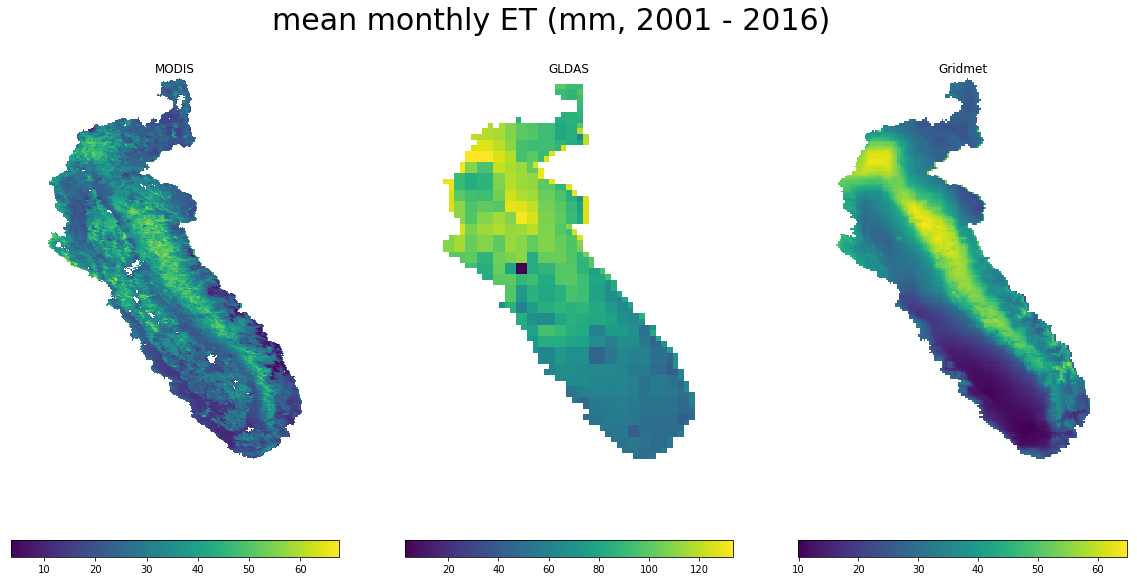

In [12]:
# normalized_cmap = matplotlib.colors.Normalize(vmin=0, vmax=50)

f = plt.figure(figsize=(20,10))

plt.suptitle("mean monthly ET (mm, 2001 - 2016)", size = 30)

plt.subplot(1,3,1)
plt.imshow(np.nanmean(m_scaled, axis = 2))
plt.colorbar(orientation='horizontal')
plt.title("MODIS")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(np.nanmean(n_scaled, axis = 2))
plt.title("GLDAS")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(np.nanmean(g_scaled, axis = 2))
plt.title("Gridmet")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.savefig("../figs/mean_monthly_ET.png")

plt.show()

In [12]:
# regress trendlines over time

In [13]:
def calc_spatial_trend(array):

    t = array.copy()

    x_array = np.arange(t.shape[2]) # time dimension

    slopes = []

    for i in range(0, t.shape[0]):
        for j in range(0, t.shape[1]):
                y_array = t[i,j,:]
                slope, intercept, r_value, p_value, std_err = stats.linregress(x_array,y_array)
                slopes.append(slope)
                
    s = np.array(slopes)
    s = s.reshape(t.shape[0],t.shape[1])
    s[s == 0 ] = np.nan
    
    return s

In [14]:
tst = calc_spatial_trend(m_scaled)
pst = calc_spatial_trend(n_scaled)
cst = calc_spatial_trend(g_scaled)

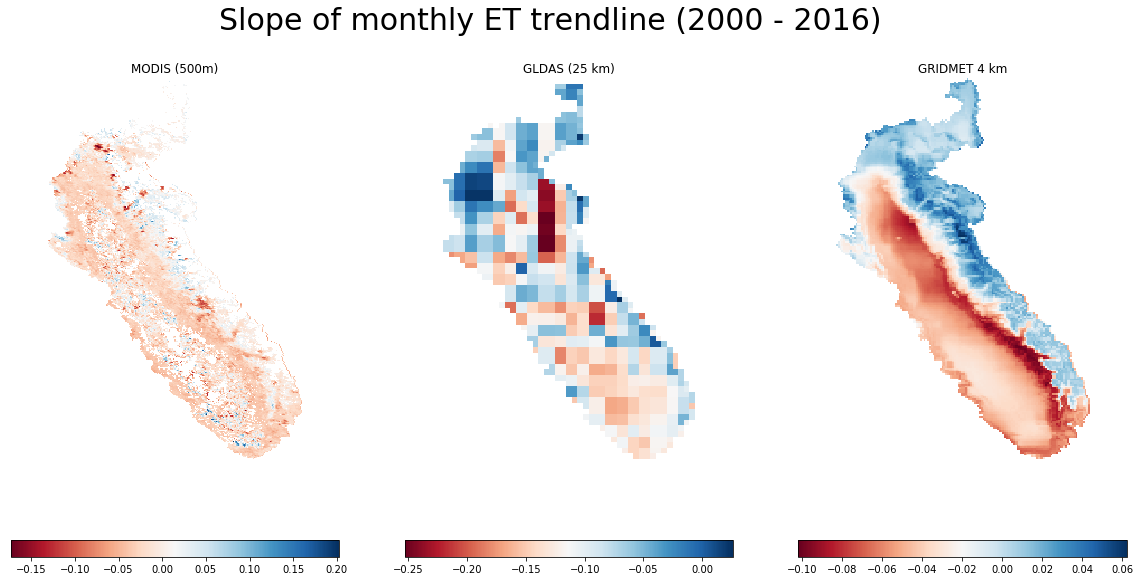

In [15]:
f = plt.figure(figsize=(20,10))

plt.suptitle("Slope of monthly ET trendline (2000 - 2016)", size = 30)

plt.subplot(1,3,1)
plt.imshow(tst,cmap = plt.get_cmap("RdBu"))
plt.colorbar(orientation='horizontal')
plt.title("MODIS (500m)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(pst,cmap = plt.get_cmap("RdBu"))
plt.title("GLDAS (25 km)")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cst,cmap = plt.get_cmap("RdBu"))
plt.title("GRIDMET 4 km")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.savefig("../figs/monthly_trend_maps_ET.png")

plt.show()

In [16]:
# Statistics

In [17]:
def get_spatial_stats(array):

    t = array.copy()

    x_array = np.arange(t.shape[2]) # time dimension

    ps = []
    rs = []

    for i in range(0, t.shape[0]):
        for j in range(0, t.shape[1]):
                y_array = t[i,j,:]
                slope, intercept, r_value, p_value, std_err = stats.linregress(x_array,y_array)
                ps.append(p_value)
                rs.append(r_value)
          
    p = np.array(ps)
    p = p.reshape(t.shape[0],t.shape[1])
    p[p == 0 ] = np.nan
    p[p == 1 ] = np.nan

    r = np.array(rs)
    r = r.reshape(t.shape[0],t.shape[1])
    r[r == 0 ] = np.nan
    
    return p,r

In [18]:
tp, tr = get_spatial_stats(m_scaled)
pp, pr = get_spatial_stats(n_scaled)
cp, cr = get_spatial_stats(g_scaled)

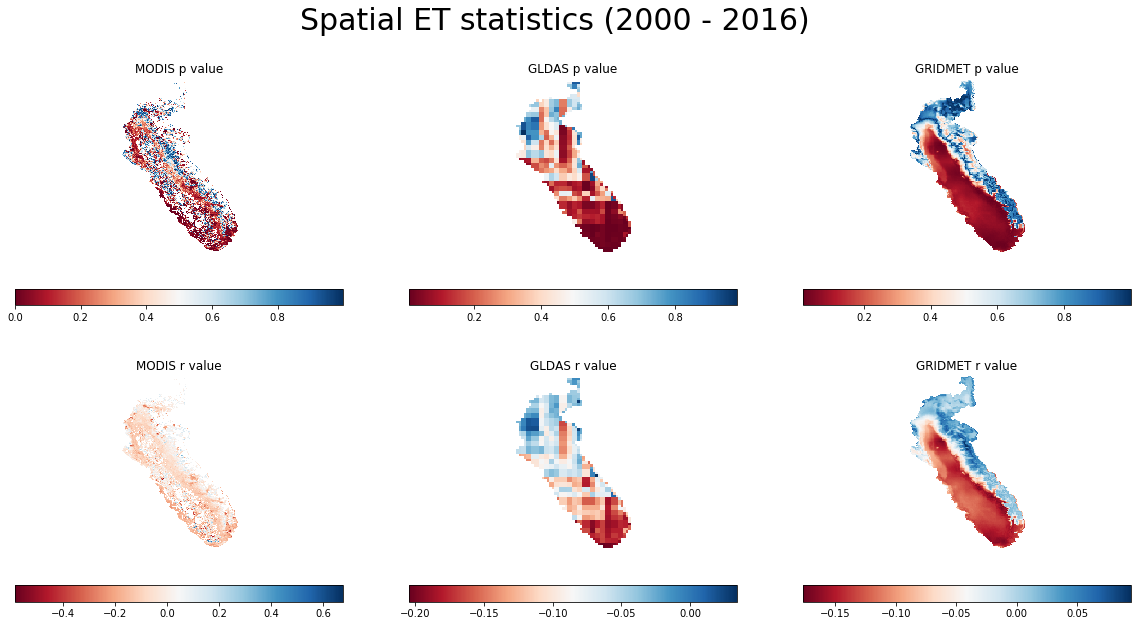

In [19]:
f = plt.figure(figsize=(20,10))

plt.suptitle("Spatial ET statistics (2000 - 2016)", size = 30)

plt.subplot(2,3,1)
plt.imshow(tp,cmap = plt.get_cmap("RdBu"))
plt.colorbar(orientation='horizontal')
plt.title("MODIS p value")
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(pp,cmap = plt.get_cmap("RdBu"))
plt.title("GLDAS p value")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(cp,cmap = plt.get_cmap("RdBu"))
plt.title("GRIDMET p value")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(tr,cmap = plt.get_cmap("RdBu"))
plt.title("MODIS r value")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(pr,cmap = plt.get_cmap("RdBu"))
plt.title("GLDAS r value")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(cr,cmap = plt.get_cmap("RdBu"))
plt.title("GRIDMET r value")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.savefig("../figs/monthly_trend_stats_ET.png")
plt.show()

In [20]:
def get_monthly_sum(array):
    arr = array.copy()
    
    totals = []
    for i in range(0,array.shape[2]):
        total = np.nanmean(array[:,:,i]) * array.shape[0] *array.shape[2]
        totals.append(total)
        
    return np.array(totals)

In [21]:
t_sums = get_monthly_sum(m_scaled) 
p_sums = get_monthly_sum(n_scaled)
c_sums = get_monthly_sum(g_scaled)

/Users/aakashahamed/anaconda3/envs/pysheds/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


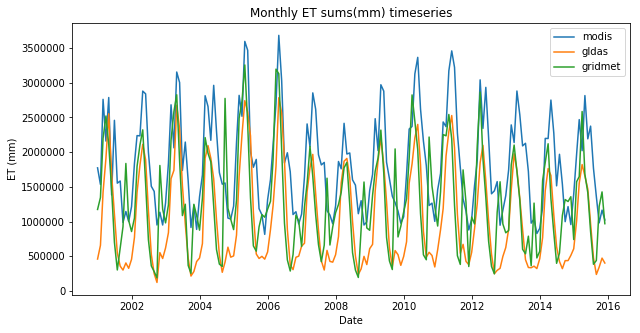

In [22]:
dates = [datetime.date(2001, 1, 1) + relativedelta(months=x) for x in range(0, 180)]

plt.figure(figsize=(10,5))
plt.title("Monthly ET sums(mm) timeseries")
plt.plot(dates,t_sums, label = "modis")
plt.plot(dates,p_sums, label = "gldas")
plt.plot(dates,c_sums, label = "gridmet")
plt.ylabel("ET (mm)")
plt.xlabel("Date")
plt.legend()

plt.savefig("../figs/monthly_timeseries_ET.png")

plt.show()

In [23]:
t_slope, t_intercept, t_r_value, t_p_value, t_std_err = stats.linregress(np.arange(0,len(dates)),t_sums)
p_slope, p_intercept, p_r_value, p_p_value, p_std_err = stats.linregress(np.arange(0,len(dates)),p_sums)
c_slope, c_intercept, c_r_value, c_p_value, c_std_err = stats.linregress(np.arange(0,len(dates)),c_sums)

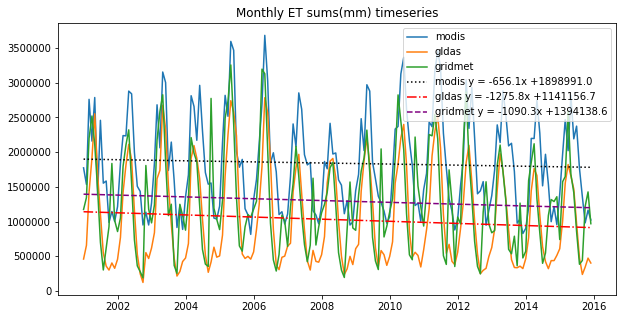

In [24]:
plt.figure(figsize=(10,5))

plt.title("Monthly ET sums(mm) timeseries")
plt.plot(dates,t_sums, label = "modis")
plt.plot(dates,p_sums, label = "gldas")
plt.plot(dates,c_sums, label = "gridmet")

plt.plot(dates, t_intercept + t_slope*np.arange(0,len(dates)), 'black', linestyle = ":",  label='modis y = {}x +{}'.format(round(t_slope,1), round(t_intercept,1)))
plt.plot(dates, p_intercept + p_slope*np.arange(0,len(dates)), 'red', linestyle = "-.", label='gldas y = {}x +{}'.format(round(p_slope,1), round(p_intercept,1)))
plt.plot(dates, c_intercept + c_slope*np.arange(0,len(dates)), 'purple', linestyle = "--", label='gridmet y = {}x +{}'.format(round(c_slope,1), round(c_intercept,1)))

plt.legend()

plt.savefig("../figs/monthly_timeseries_trendlines_ET.png")

plt.show()

In [25]:
outdf = pd.DataFrame(
    {'modis': t_sums,
     'gldas': p_sums,
     'gridmet': c_sums
    })

outdf.index = dates
outdf.head()

,modis,gldas,gridmet
2001-01-01,1.773670e+06,4.593587e+05,1.174011e+06
2001-02-01,1.534297e+06,6.572096e+05,1.345984e+06
2001-03-01,2.761055e+06,1.421961e+06,2.199432e+06
2001-04-01,2.159400e+06,1.913153e+06,2.520901e+06
2001-05-01,2.787220e+06,2.552808e+06,2.110090e+06


In [26]:
outdf.to_csv("../data/et.csv")

# animation

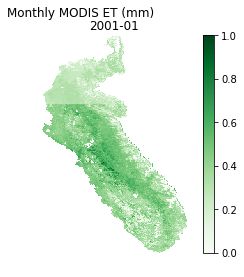

In [27]:
image = modis.copy()

# create a ScalarMappable, initialize a data structure, fake the array of the scalar mappable, set max to 99th percentile of data
sm = plt.cm.ScalarMappable(cmap="Greens")#, norm=plt.Normalize(vmin=0, vmax=1200))#vmax=np.percentile(final, 99)))
sm._A = []

s = np.shape(image)
nFrames = 12*15 # months * years
A = np.zeros((image.shape[0], image.shape[1], nFrames))

# Make the dates to be annotated
dates = []

mons = range(1,13)
yrs = range(2001,2016)

for y in yrs:
    for m in mons:
        dates.append(datetime.date(y,m,1))  #year, month, day

fig = plt.figure()
supt = plt.suptitle("Monthly MODIS ET (mm)")
title = plt.title(str(dates[0])[:-3])
ax = plt.axis('off')
cbar = plt.colorbar(sm)
im = plt.imshow(image[:,:,0], interpolation="none", cmap="Greens")

def update(t):
    im.set_array(image[:,:,t])
    title.set_text(str(dates[t])[:-3])

ani = matplotlib.animation.FuncAnimation(fig, func=update, frames=nFrames, repeat=True)

plt.show()

In [28]:
from IPython.display import HTML
HTML(ani.to_html5_video())

![title](MODIS_ET.gif)